### This notebook is mainly talking about the performance measure for classification problem(binary classication & multi-class classification)

### MNIST Dataset

In [3]:
from sklearn.datasets import fetch_mldata

#By default Scikit-Learn caches downloaded datasets in a directory called $HOME/scikit_learn_data.
mnist = fetch_mldata("MNIST original")

X, y = mnist.data, mnist.target

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


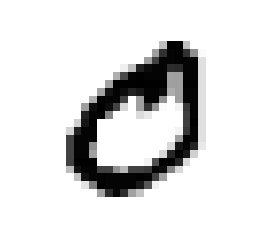

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Print one of the sample image
simple_image_digit = X[1]
simple_image = simple_image_digit.reshape(28,28)
plt.imshow(simple_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()


In [5]:
#Split dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X[shuffle_index], y[shuffle_index]

## 1. Binary classifier 

In [7]:
#Construct dataset
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=40)
sgd.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=40, shuffle=True, verbose=0,
       warm_start=False)

In [18]:
sgd.predict(simple_image_digit)

/Users/hushenglang/anaconda/envs/tensorflow/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([False], dtype=bool)

In [20]:
#this returns the confidence score for sample which is the distance of sample from hyperplane. this score can be use for percision/recall tradeoff
sgd.decision_function([simple_image_digit])

array([-407306.1872796])

### Using Accuracy of  Cross Validation for performance measurement

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.94525,  0.9211 ,  0.94985])

**Note**: From the accuracy, it looks great. But indeed it is not since the dataset is skewed, 90% of dataset is not-5, only 10% of dataset is 5.
So that tells us that accuracy is genrally not the perfered performance measurement for classification problem, especially for skewed dataset.

### Using Confusion Matrix of Cross Validation for performance measurement
**Note**: cross_val_predict will concat all validation folds prediction into one array result.

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_5_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_5_pred)

array([[51766,  2813],
       [  863,  4558]])

**Note:** Each row represent actual class, while each column represent predicat class.

C00(53399) is True Negative, C00(53399)is True Nagetive, C11(4327) is True Positive, C01(1180) is False Positive, C10(1094) is False Negative

In [13]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

In [14]:
# Precision, Recall and F1-Score
from sklearn.metrics import precision_score, recall_score
p_score = precision_score(y_train_5, y_train_5_pred)
r_score=recall_score(y_train_5, y_train_5_pred)
print(p_score, r_score)

0.618369285036 0.840804279653


In [15]:
from sklearn.metrics import f1_score
f1score=f1_score(y_train_5, y_train_5_pred)
print(f1score)

0.71263289556


**Note:** F1-score favors the classifer which has similar precision and recall. However, in some context you may want higher percision which is overfitting to positive, in other context you may want higher recall which is overfitting to negative. so we need to tradeoff precision/recall, we can not increase both.

### percision/recall tradeoff

In [40]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
distances = cross_val_predict(sgd, X_train, y_train_5, cv=3, method="decision_function")
thresholds = [0, 1000, 10000, 100000, 1000000]
for threshold in thresholds:
    ascore = accuracy_score((distances>threshold), y_train_5)
    print("threshold-"+str(threshold)+": "+str(ascore))

threshold-0: 0.938733333333
threshold-1000: 0.939266666667
threshold-10000: 0.942466666667
threshold-100000: 0.960516666667
threshold-1000000: 0.909716666667


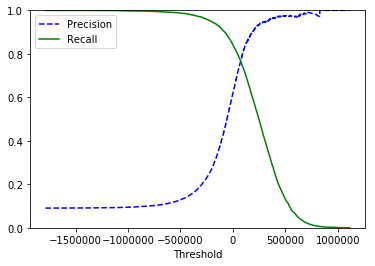

In [51]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, distances)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.ylim([0, 1])
plt.show()

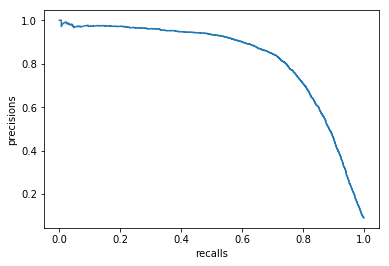

In [66]:
#plot precision/recall curve
plt.plot(recalls, precisions)
plt.xlabel("recalls")
plt.ylabel("precisions")
plt.show()

In [114]:
#by setting threshold, you can tradeoff precision and recall.
y_scores = sgd.decision_function(X_train)
pscore = precision_score(y_train_5,(y_scores > 100000))
rscore = recall_score(y_train_5, (y_scores > 100000))
print(pscore, rscore)

0.982608695652 0.250138350858


**Note**: precision_score(), recall_score() methods, the function param must be y_train, y_predict.

**The ROC Curve**

ROC Curve is similiar to PR Curve, instead of plotting percision/recall curve, it plot True Positive/False Positive Curve.

When the positive is rare and when you care more false positive than false negative, then using precision/recall curve, otherwise using ROC curve.


## 2. MultiClass Classification

**Random Forest** and **Naive Bayes** can directly handle multiclass classification.

**SVM** and **Linear Classifier** are strictly binary classifiers.So to support multiclass classification for them, there are 2 techniques.

one is called "one-vs-all" which build multiple binary classifier to do so.

other is call "one-vs-one" which build multiple binary classifier for each pair of sample.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multi‐ class classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO).

In [118]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.86282743,  0.86739337,  0.83882582])

In [123]:
#feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [125]:
#after feature scaling, the accuracy is better since the error function could get better converage.
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91056789,  0.90824541,  0.90853628])

In [128]:
y_train_predict = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
confu_matrix = confusion_matrix(y_train, y_train_predict)
confu_matrix

array([[5736,    3,   23,    8,   12,   43,   46,    8,   41,    3],
       [   2, 6461,   48,   29,    6,   39,    7,   11,  129,   10],
       [  52,   37, 5335,   97,   78,   25,  102,   57,  161,   14],
       [  50,   40,  139, 5341,    2,  228,   35,   57,  145,   94],
       [  17,   28,   43,    8, 5360,   13,   59,   35,   88,  191],
       [  71,   38,   40,  180,   79, 4602,  109,   29,  193,   80],
       [  31,   22,   42,    1,   42,   85, 5639,    4,   52,    0],
       [  23,   24,   74,   33,   53,   12,    8, 5795,   17,  226],
       [  46,  152,   68,  142,   13,  150,   60,   30, 5051,  139],
       [  39,   36,   28,   86,  168,   41,    3,  234,   87, 5227]])

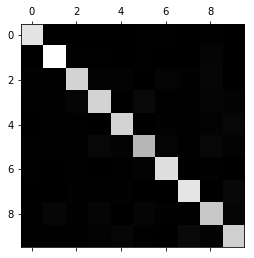

In [130]:
plt.matshow(confu_matrix, cmap=plt.cm.gray)
plt.show()

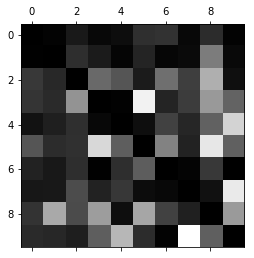

In [146]:
row_sums = confu_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = confu_matrix / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()